In [93]:
from medmnist import PneumoniaMNIST
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import pennylane as qml
import torch
from pennylane import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
import seaborn as sns
from pennylane import draw_mpl
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

from pennylane.qnn import TorchLayer

In [94]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [95]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [96]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [97]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [98]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [99]:
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)

In [100]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_loader)

In [101]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


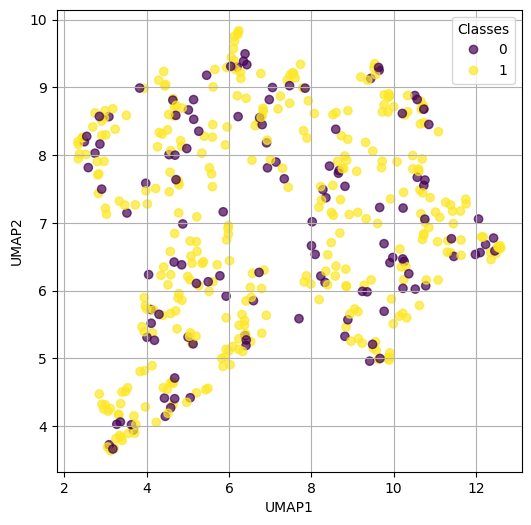

In [102]:
y_train = torch.cat([y for _, y in train_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


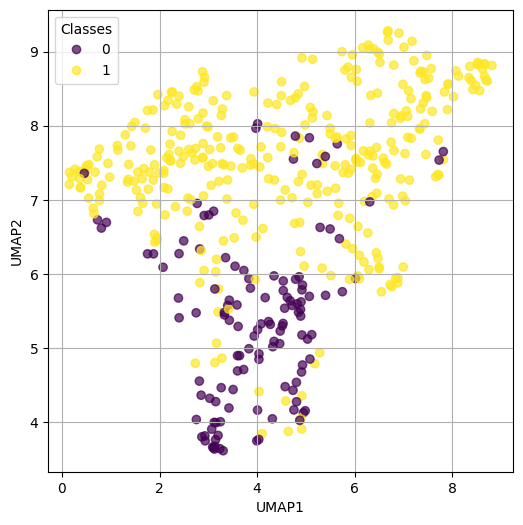

In [103]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

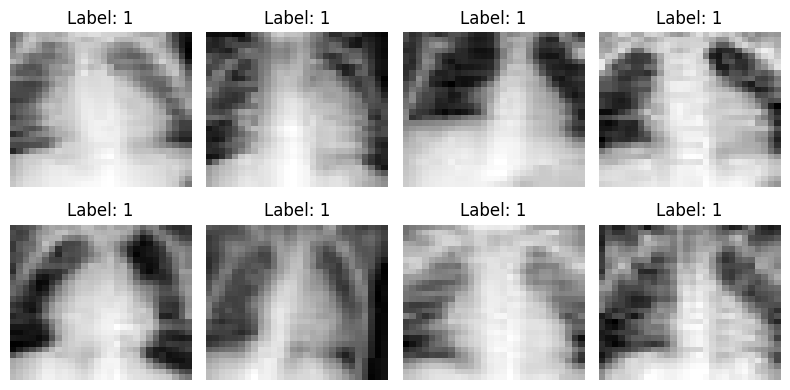

In [104]:
#original images
x_batch, y_batch = sample_batch(train_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_121871/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


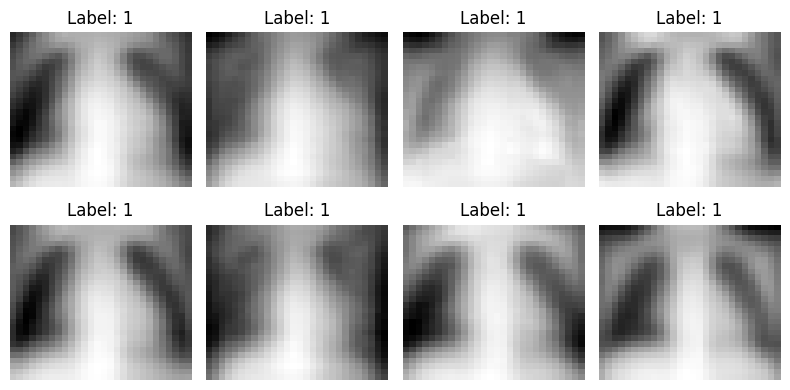

In [105]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

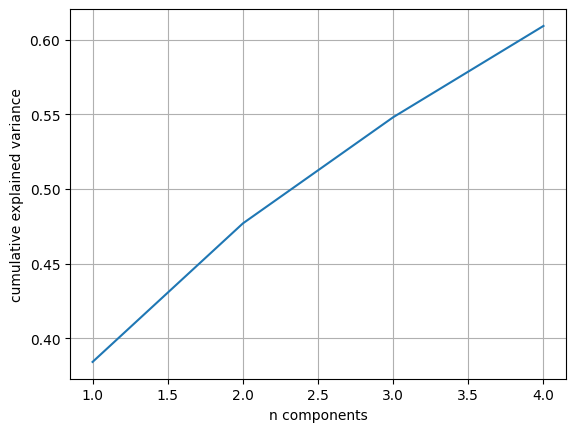

In [106]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

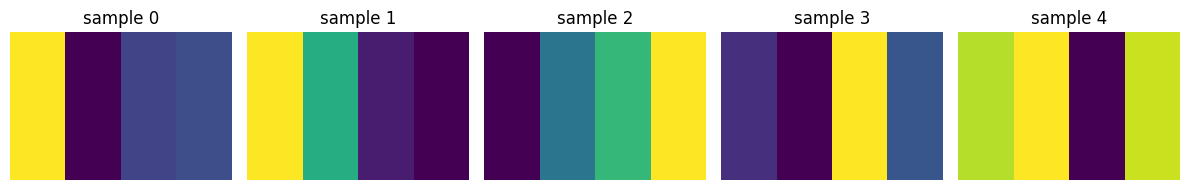

In [107]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [108]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [109]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


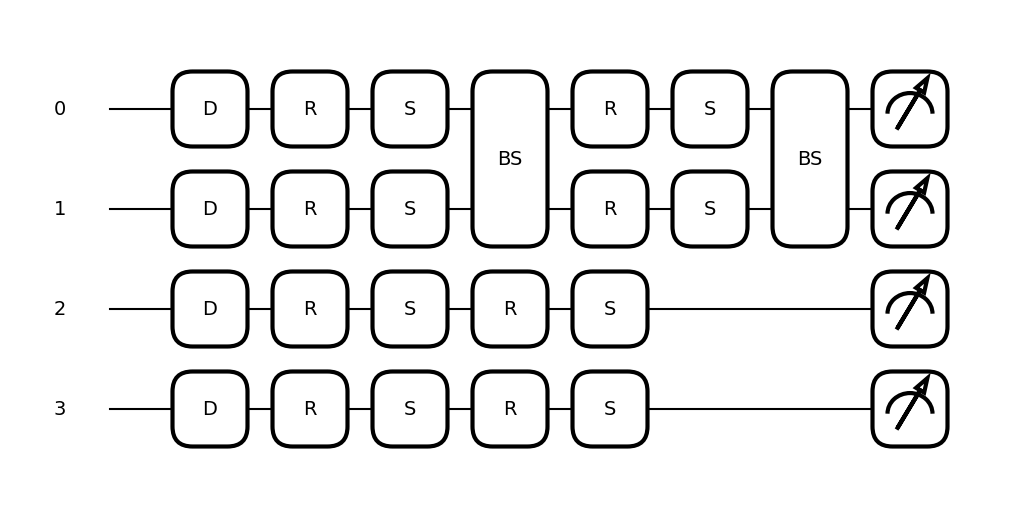

In [110]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)
x_test_scaled = scaler.fit_transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [112]:
print(x_train_tensor[0])

tensor([0.2297, 0.1442, 0.2080, 0.3217])


In [113]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [114]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

In [115]:
print(output)

tensor([-0.1093, -0.0640,  0.1971, -0.0209], dtype=torch.float64)


In [116]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [117]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [151]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.head(x)

In [136]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # print(x_batch.shape)
        optimizer.zero_grad()
        logits = model(x_batch)
        y_batch = y_batch.view(-1).long()
        # print(logits.shape)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    return avg_loss, avg_acc

In [140]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    with torch.no_grad():
        for x_batch, y_batch in progress_bar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            y_batch = y_batch.view(-1).long()
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * x_batch.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total_samples += x_batch.size(0)

            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(correct/total_samples):.4f}"
            })

        avg_loss = total_loss / total_samples
        avg_acc = correct / total_samples
        return avg_loss, avg_acc

In [141]:
epochs = 10
device = "cpu"
cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumWrapper                           --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 146
Trainable params: 146
Non-trainable params: 0

In [143]:
train_metrics = {
    "acc": [], "loss": []
}
val_metrics = {
    "acc": [], "loss": []
}

for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(cv_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(cv_model, val_loader, criterion, device)

    train_metrics["acc"].append(train_acc)
    train_metrics["loss"].append(train_loss)
    val_metrics["acc"].append(val_acc)
    val_metrics["loss"].append(val_loss)
    
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
    # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

epoch 1/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.58it/s, loss=0.7551, acc=0.6336]


Train loss: 0.8055 | Train acc: 0.5979 | Val loss: 0.7006 | Val acc: 0.6336
epoch 2/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.61it/s, loss=0.4921, acc=0.7195]


Train loss: 0.5849 | Train acc: 0.6681 | Val loss: 0.5277 | Val acc: 0.7195
epoch 3/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.60it/s, loss=0.4765, acc=0.7844]


Train loss: 0.4831 | Train acc: 0.7362 | Val loss: 0.4326 | Val acc: 0.7844
epoch 4/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.56it/s, loss=0.3126, acc=0.8187]


Train loss: 0.4200 | Train acc: 0.8000 | Val loss: 0.3692 | Val acc: 0.8187
epoch 5/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.48it/s, loss=0.5656, acc=0.8760]


Train loss: 0.3751 | Train acc: 0.8426 | Val loss: 0.3257 | Val acc: 0.8760
epoch 6/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.73it/s, loss=0.5053, acc=0.8798]


Train loss: 0.3448 | Train acc: 0.8617 | Val loss: 0.2982 | Val acc: 0.8798
epoch 7/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.52it/s, loss=0.2132, acc=0.8874]


Train loss: 0.3246 | Train acc: 0.8660 | Val loss: 0.2808 | Val acc: 0.8874
epoch 8/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.47it/s, loss=0.1905, acc=0.8817]


Train loss: 0.3123 | Train acc: 0.8702 | Val loss: 0.2736 | Val acc: 0.8817
epoch 9/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.45it/s, loss=0.3133, acc=0.8874]


Train loss: 0.3041 | Train acc: 0.8638 | Val loss: 0.2686 | Val acc: 0.8874
epoch 10/10


Training: 100%|████████| 17/17 [00:01<00:00, 11.63it/s, loss=0.4451, acc=0.8874]

Train loss: 0.2966 | Train acc: 0.8638 | Val loss: 0.2657 | Val acc: 0.8874


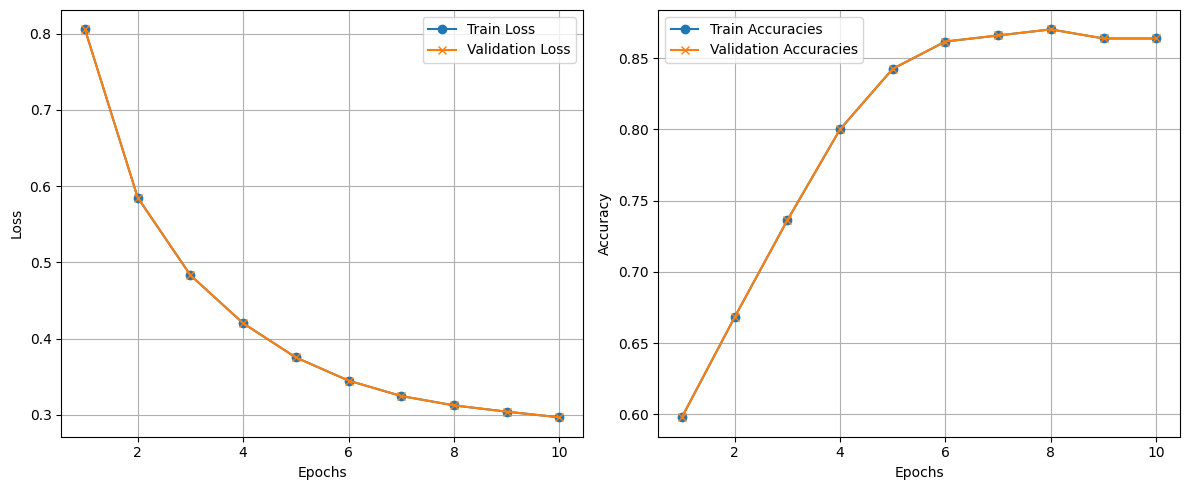

In [150]:

epochs = range(1, len(train_metrics["acc"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)    

plt.tight_layout()
plt.show()

## CLASSICAL MODEL

In [167]:
epochs = 10
# epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 114
Trainable params: 114
Non-trainable params: 0

In [168]:
c_train_metrics = {
    "acc": [], "loss": []
}
c_val_metrics = {
    "acc": [], "loss": []
}

for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)

    c_train_metrics["acc"].append(train_acc)
    c_train_metrics["loss"].append(train_loss)
    c_val_metrics["acc"].append(val_acc)
    c_val_metrics["loss"].append(val_loss)
    
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
    # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

epoch 1/10


Training: 100%|███████| 17/17 [00:00<00:00, 393.21it/s, loss=0.5725, acc=0.7882]


Train loss: 0.6251 | Train acc: 0.7638 | Val loss: 0.6147 | Val acc: 0.7882
epoch 2/10


Training: 100%|███████| 17/17 [00:00<00:00, 390.03it/s, loss=0.5884, acc=0.7729]


Train loss: 0.6075 | Train acc: 0.7723 | Val loss: 0.5976 | Val acc: 0.7729
epoch 3/10


Training: 100%|███████| 17/17 [00:00<00:00, 419.75it/s, loss=0.5497, acc=0.7729]


Train loss: 0.5909 | Train acc: 0.7638 | Val loss: 0.5817 | Val acc: 0.7729
epoch 4/10


Training: 100%|███████| 17/17 [00:00<00:00, 437.12it/s, loss=0.5965, acc=0.7729]


Train loss: 0.5750 | Train acc: 0.7574 | Val loss: 0.5655 | Val acc: 0.7729
epoch 5/10


Training: 100%|███████| 17/17 [00:00<00:00, 412.03it/s, loss=0.4857, acc=0.7748]


Train loss: 0.5586 | Train acc: 0.7681 | Val loss: 0.5488 | Val acc: 0.7748
epoch 6/10


Training: 100%|███████| 17/17 [00:00<00:00, 419.08it/s, loss=0.5283, acc=0.7729]


Train loss: 0.5424 | Train acc: 0.7681 | Val loss: 0.5307 | Val acc: 0.7729
epoch 7/10


Training: 100%|███████| 17/17 [00:00<00:00, 433.49it/s, loss=0.5683, acc=0.7844]


Train loss: 0.5249 | Train acc: 0.7723 | Val loss: 0.5124 | Val acc: 0.7844
epoch 8/10


Training: 100%|███████| 17/17 [00:00<00:00, 428.37it/s, loss=0.6175, acc=0.7882]


Train loss: 0.5068 | Train acc: 0.7723 | Val loss: 0.4938 | Val acc: 0.7882
epoch 9/10


Training: 100%|███████| 17/17 [00:00<00:00, 404.15it/s, loss=0.3687, acc=0.7901]


Train loss: 0.4891 | Train acc: 0.7723 | Val loss: 0.4739 | Val acc: 0.7901
epoch 10/10


Training: 100%|███████| 17/17 [00:00<00:00, 426.73it/s, loss=0.3972, acc=0.7958]

Train loss: 0.4705 | Train acc: 0.7787 | Val loss: 0.4541 | Val acc: 0.7958


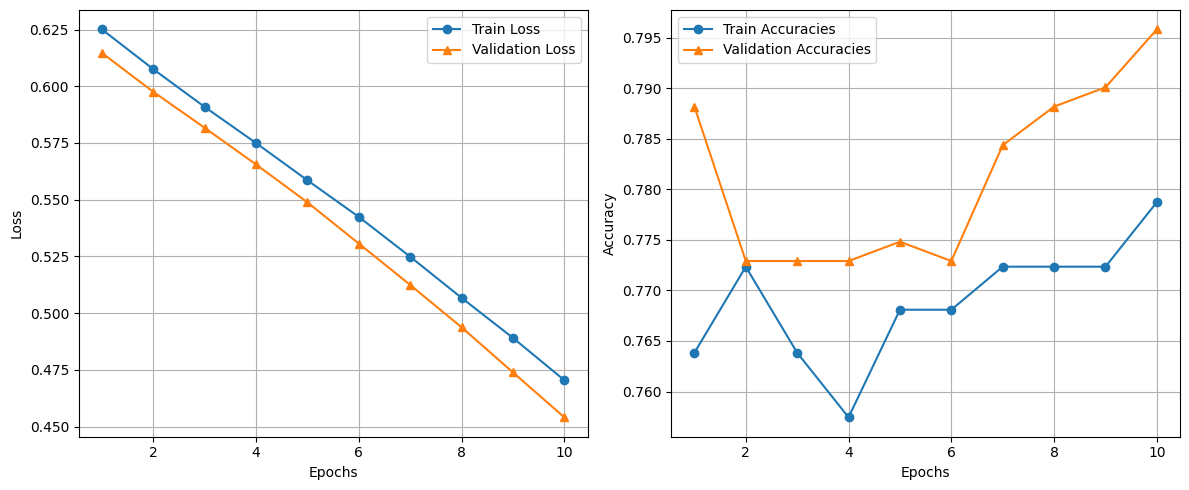

In [169]:
epochs = range(1, len(c_train_metrics["acc"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)    

plt.tight_layout()
plt.show()